In [1]:
!pip install "gluonts[mxnet,pro]"
!pip install "gluonts[torch,pro]"
!pip install yfinance


In [5]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (30, 10)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## GlutonTs Basic Example

100%|██████████| 50/50 [00:01<00:00, 31.73it/s, epoch=5/5, avg_epoch_loss=4.02]


<AxesSubplot:>

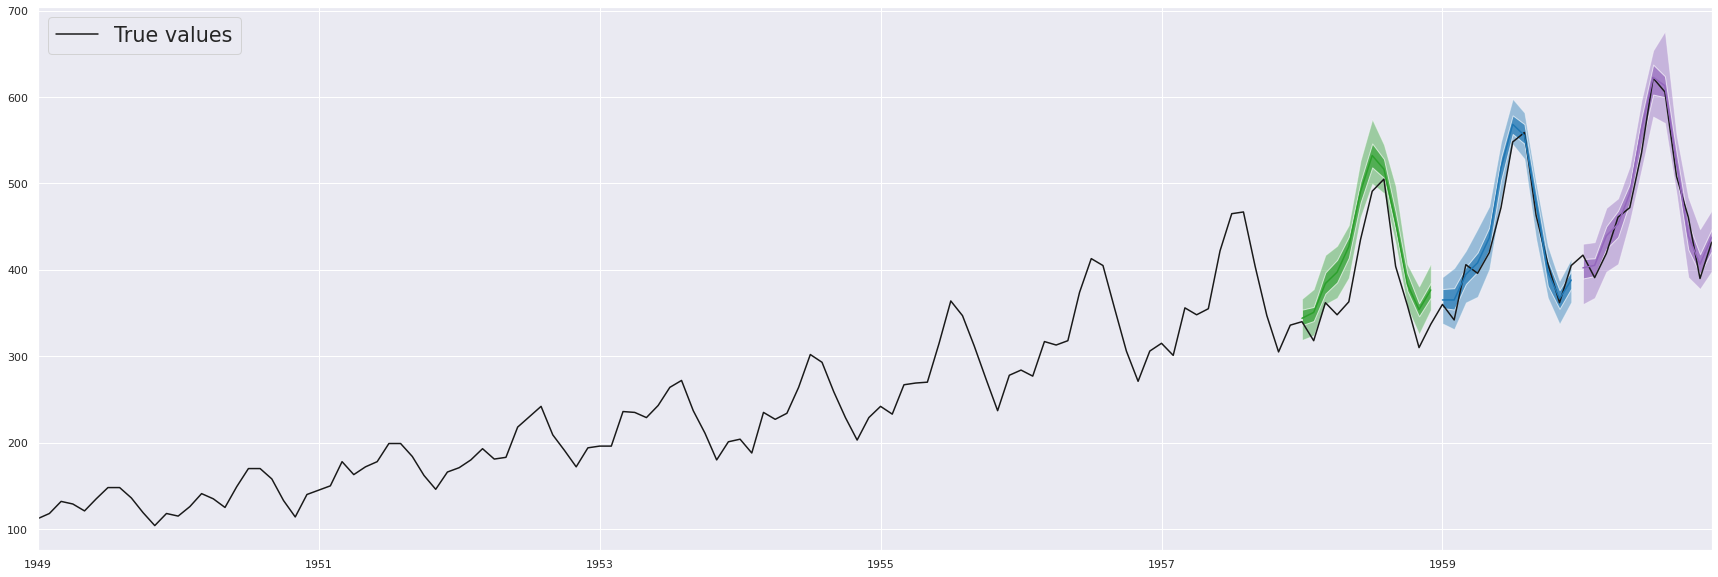

In [4]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer

dataset = get_dataset("airpassengers")

estimator = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = estimator.train(dataset.train)

# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

100%|██████████| 50/50 [00:00<00:00, 59.87it/s, epoch=5/5, avg_epoch_loss=4.93]


<AxesSubplot:>

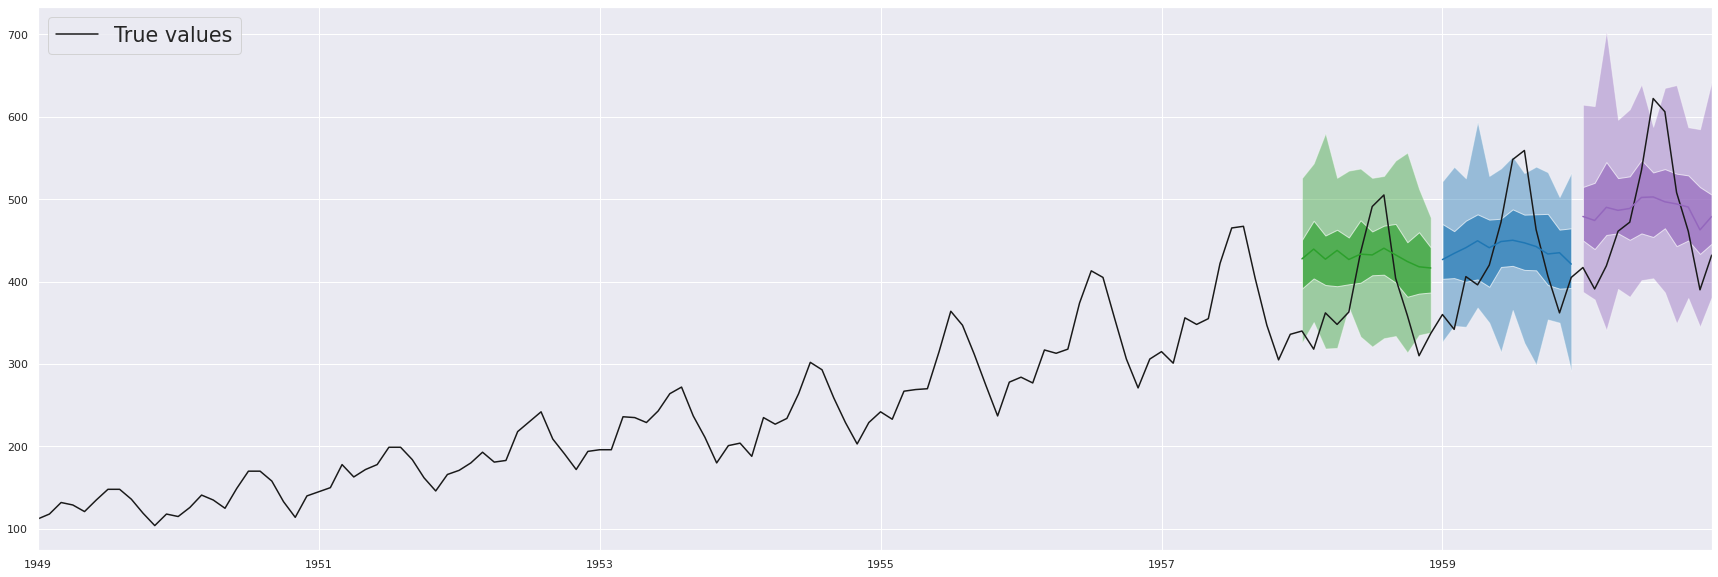

In [5]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.transformer import TransformerEstimator
from gluonts.mx import Trainer

dataset = get_dataset("airpassengers")

estimator = TransformerEstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = estimator.train(dataset.train)

# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

## BTC-USD Dataset

In [6]:
df_btc_usd = yf.download("BTC-USD")
df_btc_usd.shape
df_btc_usd.dtypes
df_btc_usd.columns
df_btc_usd.head()
df_btc_usd.index

df_btc_usd = df_btc_usd.asfreq('d')
pd.infer_freq(df_btc_usd.asfreq('d').index)

[*********************100%***********************]  1 of 1 completed


(2942, 6)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30',
               '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04',
               '2022-10-05', '2022-10-06'],
              dtype='datetime64[ns]', name='Date', length=2942, freq=None)

'D'

In [7]:
# keep only CLose column
df_btc_usd = pd.DataFrame(df_btc_usd['Close'])
df_btc_usd = df_btc_usd[df_btc_usd.index > '2021-01-01']
df_btc_usd.shape

(643, 1)

<AxesSubplot:xlabel='Date'>

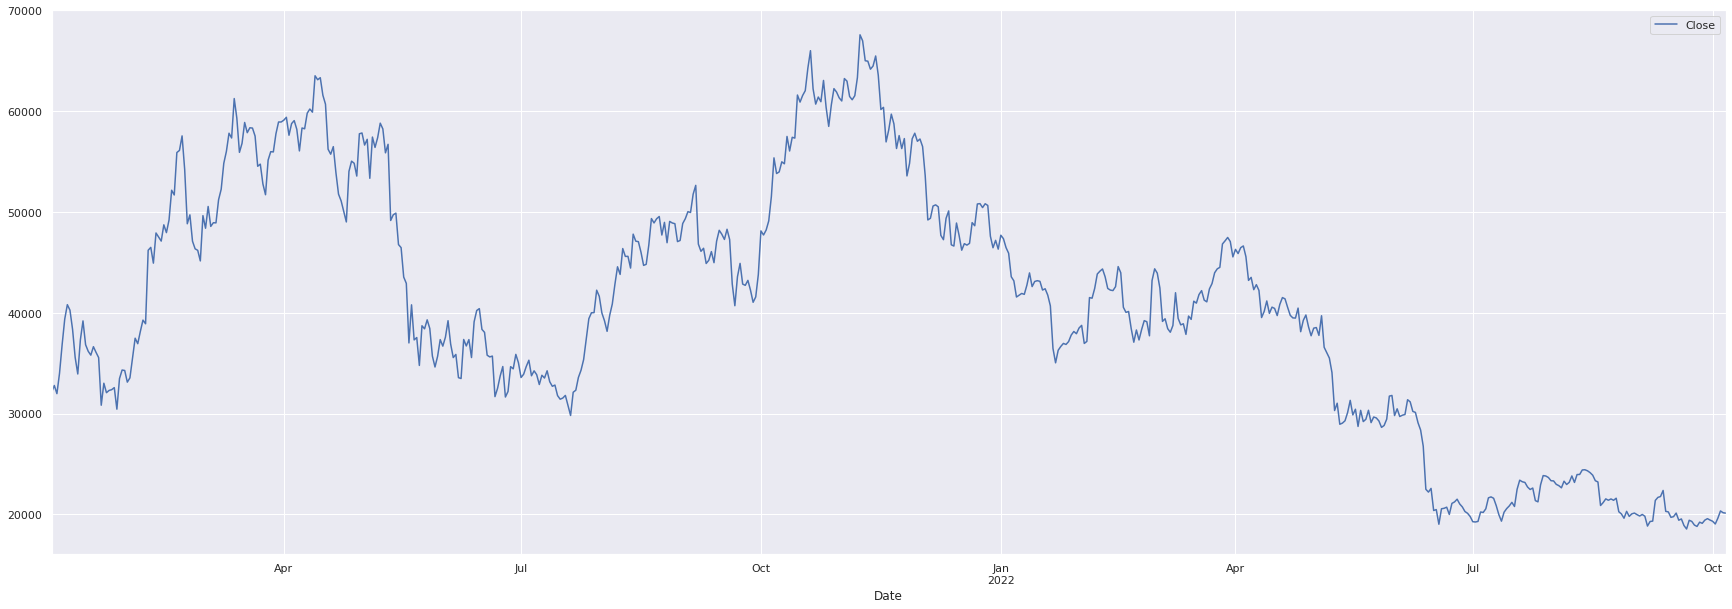

In [8]:
df_btc_usd.plot()

In [9]:
type(df_btc_usd)
type(df_btc_usd.index)
# df_btc_usd.index = df_btc_usd.index.strftime('%Y-%m-%d')
df_btc_usd

pandas.core.frame.DataFrame

pandas.core.indexes.datetimes.DatetimeIndex

,Close
Date,
2021-01-02,32127.267578
2021-01-03,32782.023438
2021-01-04,31971.914062
2021-01-05,33992.429688
2021-01-06,36824.363281
...,...
2022-10-02,19044.107422
2022-10-03,19623.580078
2022-10-04,20336.843750


In [10]:
from gluonts.dataset.common import ListDataset

freq = "1d"
start = pd.Period("02-01-2021", freq=freq)
prediction_length = 10

train_ds = ListDataset(
    [{"start": df_btc_usd.index[0], "target": df_btc_usd.Close[:-prediction_length]}],
    freq=freq
)

test_ds = ListDataset(
    [{"start": df_btc_usd.index[0], "target": df_btc_usd.Close[:]}],
    freq=freq
)


In [11]:
type(train_ds)
train_ds

gluonts.itertools.Map

Map(data=[{'start': Timestamp('2021-01-02 00:00:00', freq='D'), 'target': Date
2021-01-02    32127.267578
2021-01-03    32782.023438
2021-01-04    31971.914062
2021-01-05    33992.429688
2021-01-06    36824.363281
                  ...     
2022-09-22    19413.550781
2022-09-23    19297.638672
2022-09-24    18937.011719
2022-09-25    18802.097656
2022-09-26    19222.671875
Freq: D, Name: Close, Length: 633, dtype: float64}])

100%|██████████| 50/50 [00:00<00:00, 50.22it/s, epoch=5/5, avg_epoch_loss=9.91]


<AxesSubplot:>

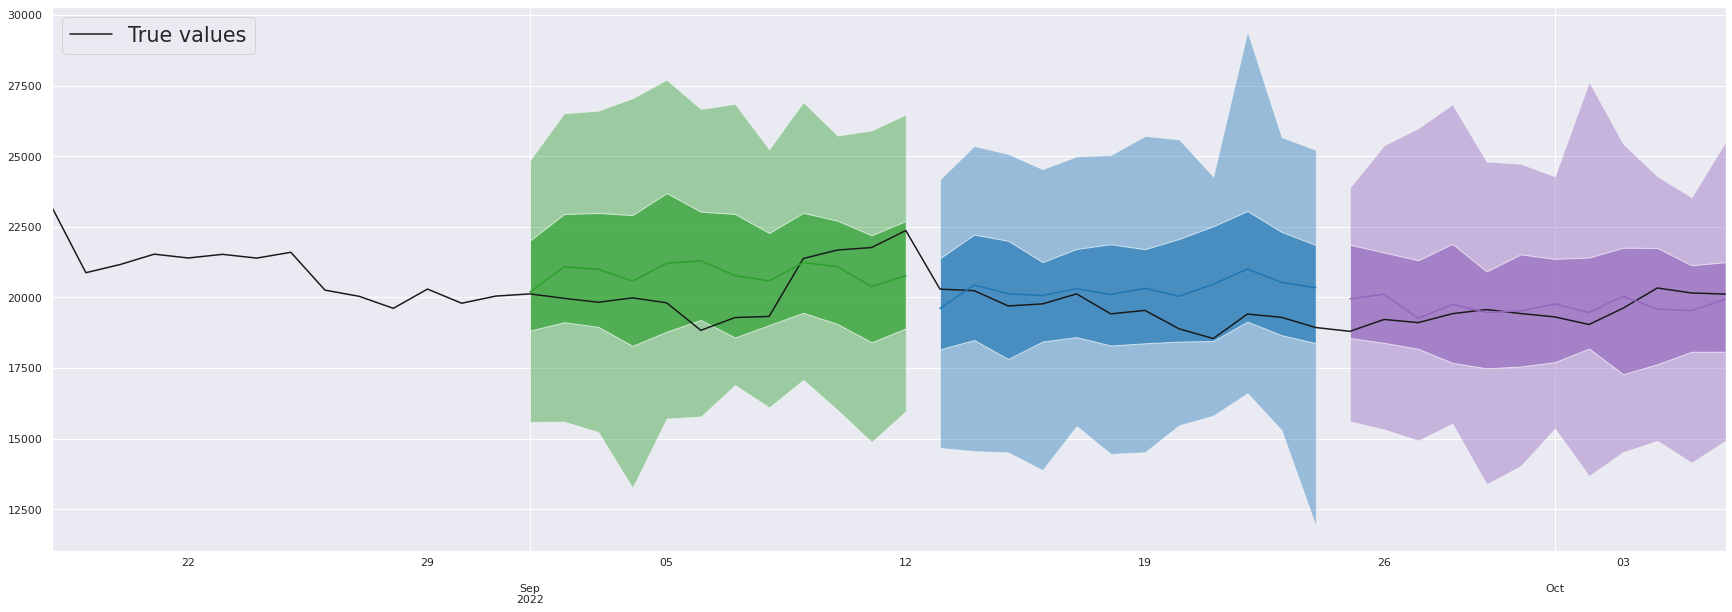

In [12]:
estimator = TransformerEstimator(prediction_length=12, freq=freq, trainer=Trainer(epochs=5))
predictor = estimator.train(training_data=train_ds)

# Make predictions
true_values = to_pandas(list(test_ds)[0])
true_values[-50:].to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [13]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [14]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(
    -1,
)
dataset_test_entry = next(iter(test_ds))
dataset_test_entry["target"][:5]


array([32127.268, 32782.023, 31971.914, 33992.43 , 36824.363],
      dtype=float32)

array([32127.268, 32782.023, 31971.914, 33992.43 , 36824.363],
      dtype=float32)

In [15]:
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2022-09-25
Frequency of the time series: <Day>


In [16]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [19648.107 19606.22  19855.91  19667.693 19645.4   19577.523 20443.996
 20364.014 20332.541 20773.932 20500.525 20719.258]
0.5-quantile (median) of the future window:
 [19762.018 19563.5   19701.09  19691.332 19699.436 19667.12  20530.473
 20343.88  20469.762 20912.682 20517.191 20750.451]


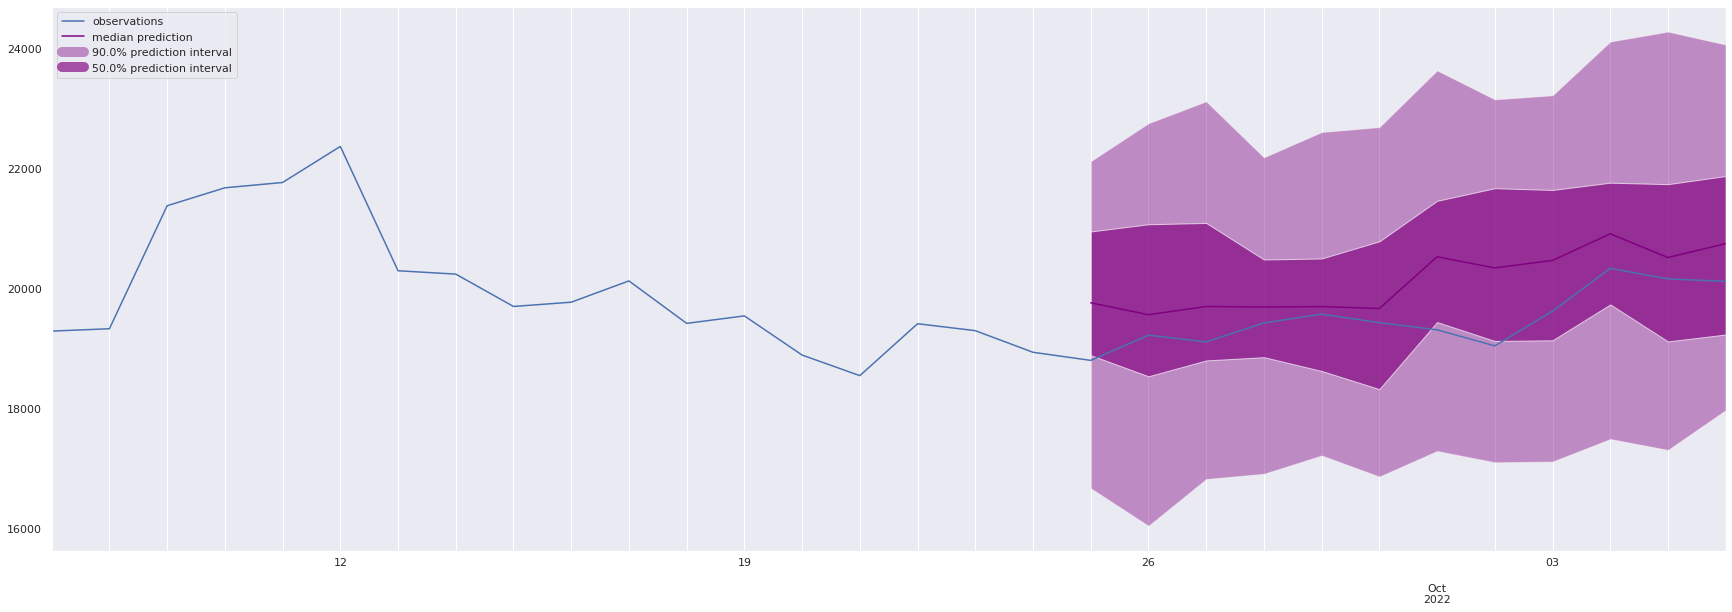

In [17]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 30
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + \
             [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1)
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="purple")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)


In [18]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics, indent=4))


Running evaluation: 1it [00:00,  2.53it/s]

{
    "MSE": 474453.2083333333,
    "abs_error": 7443.783203125,
    "abs_target_sum": 234165.15625,
    "abs_target_mean": 19513.763020833332,
    "seasonal_error": 1154.7063492063492,
    "MASE": 0.537206076119212,
    "MAPE": 0.031968181331952415,
    "sMAPE": 0.031284322341283165,
    "MSIS": 6.955625066583959,
    "QuantileLoss[0.1]": 4168.45234375,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 7443.783203125,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 6807.371874999999,
    "Coverage[0.9]": 1.0,
    "RMSE": 688.8056390109864,
    "NRMSE": 0.03529845259858911,
    "ND": 0.03178860306260872,
    "wQuantileLoss[0.1]": 0.017801334795086533,
    "wQuantileLoss[0.5]": 0.03178860306260872,
    "wQuantileLoss[0.9]": 0.029070814736127073,
    "mean_absolute_QuantileLoss": 6139.869140625,
    "mean_wQuantileLoss": 0.02622025086460744,
    "MAE_Coverage": 0.2333333333333333,
    "OWA": NaN
}


In [19]:
df_btc_usd.reset_index().to_csv('btc-usd.csv')

sources :
 <https://ts.gluon.ai/stable/tutorials/forecasting/quick_start_tutorial.html>
 <https://aws.amazon.com/fr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/>


## BTC-USD Hourly - Bitstamp

In [6]:
btc_usd_h = pd.read_csv("data/Bitstamp_BTCUSD_1h.csv")
btc_usd_h = btc_usd_h.iloc[::-1]
btc_usd_h = btc_usd_h[["date", "close"]]
btc_usd_h.set_index("date", inplace=True)
btc_usd_h.head()
btc_usd_h.shape

,close
date,
2018-05-15 06:00:00,8740.99
2018-05-15 07:00:00,8739.00
2018-05-15 08:00:00,8728.49
2018-05-15 09:00:00,8708.32
2018-05-15 10:00:00,8795.90


(38467, 1)

(15385, 1)

<AxesSubplot:xlabel='date'>

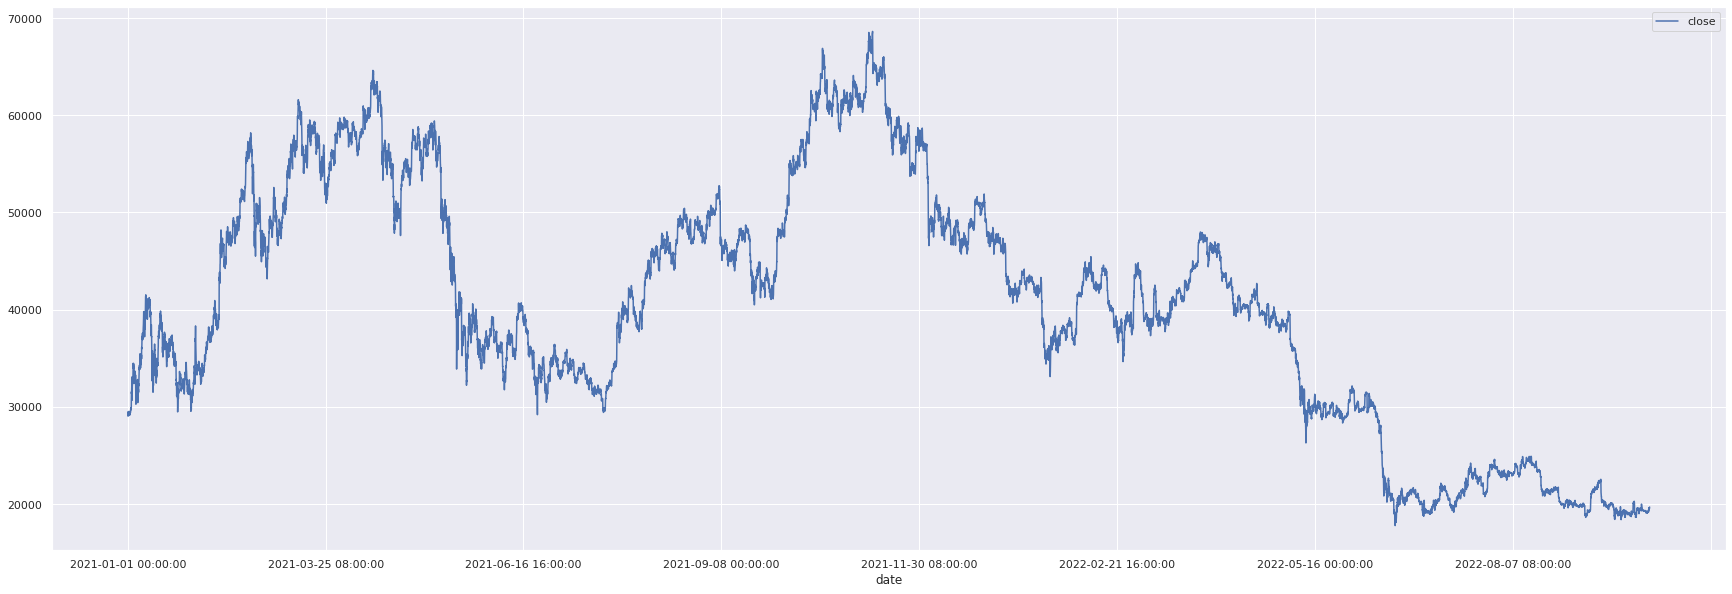

In [7]:
# let's keep only the latests values which represents the actual behavior
btc_usd_h = btc_usd_h[btc_usd_h.index > "2021-01-01"]
btc_usd_h.shape
btc_usd_h.plot()

### Auto Arima

In [2]:
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima


In [9]:
f = Forecaster(y=btc_usd_h.close,current_dates=btc_usd_h.index)
f

Forecaster(
    DateStartActuals=2021-01-01T00:00:00.000000000
    DateEndActuals=2022-10-04T00:00:00.000000000
    Freq=H
    N_actuals=15385
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [10]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2,
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=223548.002, Time=14.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=223562.198, Time=0.27 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=223563.969, Time=2.49 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=223563.788, Time=2.65 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=223560.246, Time=0.14 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=223557.778, Time=23.81 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=223557.959, Time=23.05 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=223538.823, Time=50.83 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=223536.959, Time=41.46 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=223545.108, Time=6.69 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=223539.324, Time=7.59 sec
 ARIMA(3,1,1)(2,0,0)[12] intercept   : AIC=223538.626, Time=34.48 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=223538.386, Time=27.54 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=223542.887

ForecastError: before calling a model, please make sure you have generated future dates by calling generate_future_dates(), set_last_future_date(), or ingest_Xvars_df(use_future_dates=True)

ValueError: max() arg is an empty sequence

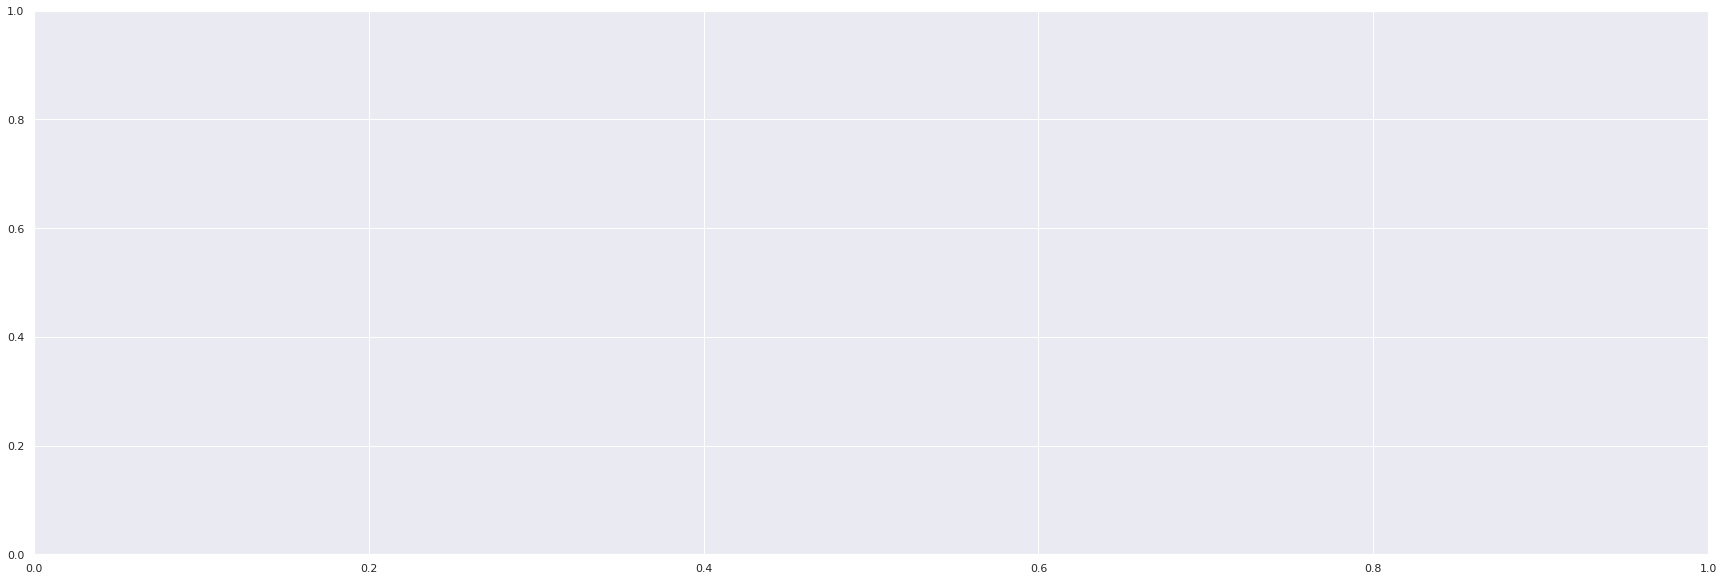

In [11]:
f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

In [ ]:
f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [ ]:
f.regr.summary()

### GluonTS - Transformer model

In [22]:
from gluonts.dataset.common import ListDataset

freq = "1h"
start = pd.Period("2021-02-01 00:00:00", freq=freq)
prediction_length = 72

train_ds = ListDataset(
    [{"start": btc_usd_h.index[0], "target": btc_usd_h.close[:-prediction_length]}],
    freq=freq
)

test_ds = ListDataset(
    [{"start": btc_usd_h.index[0], "target": btc_usd_h.close[:]}],
    freq=freq
)

In [23]:
estimator = TransformerEstimator(prediction_length=prediction_length, freq=freq, trainer=Trainer(epochs=5))
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:16<00:00,  3.04it/s, epoch=5/5, avg_epoch_loss=8.46]


<AxesSubplot:>

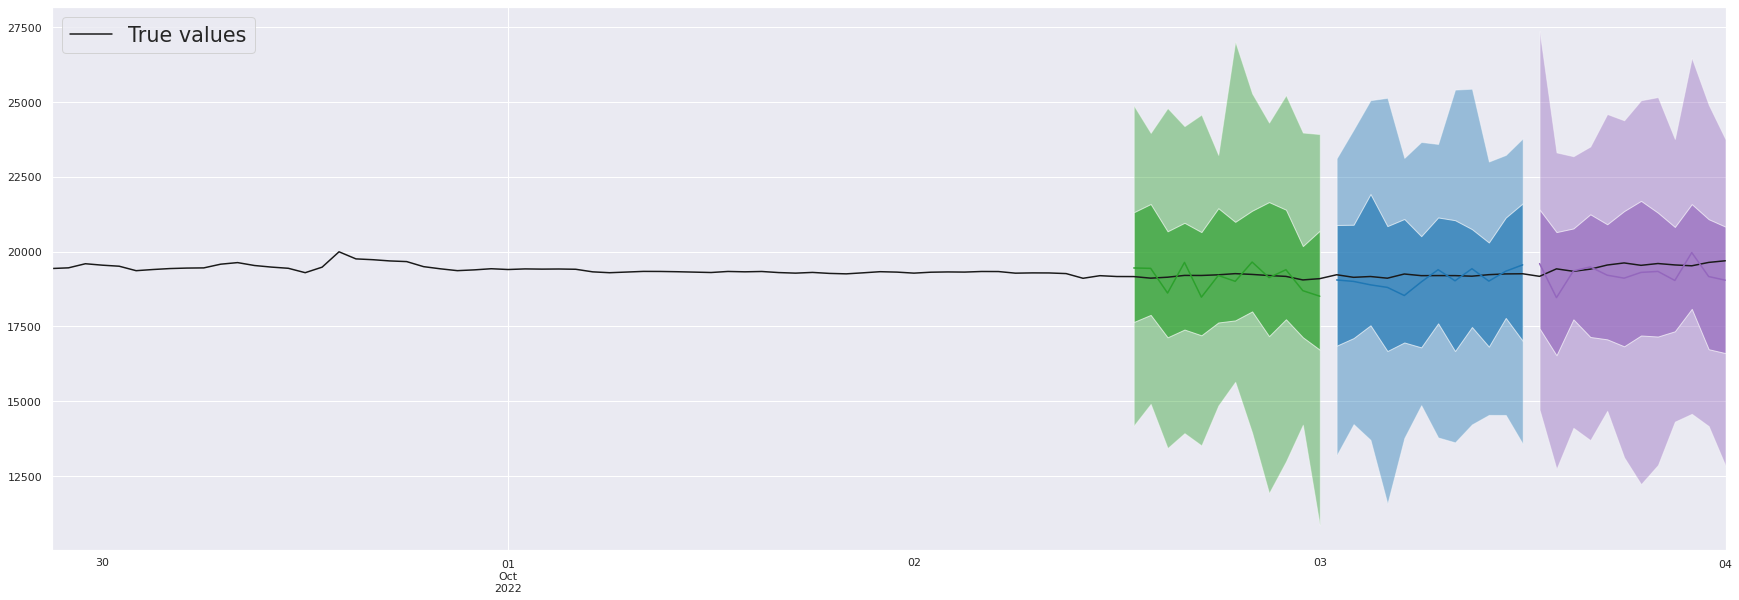

In [24]:

# Make predictions
true_values = to_pandas(list(test_ds)[0])
true_values[-100:].to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [25]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [26]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(
    -1,
)
dataset_test_entry = next(iter(test_ds))
dataset_test_entry["target"][:5]

array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 ], dtype=float32)

array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 ], dtype=float32)

In [27]:
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Number of sample paths: 100
Dimension of samples: (100, 72)
Start date of the forecast window: 2022-10-01 01:00
Frequency of the time series: <Hour>
Mean of the future window:
 [20014.46  19840.84  20032.596 20065.477 20075.424 20174.133 20318.863
 20165.176 19948.902 20283.55  20085.502 19950.088 19920.49  20081.615
 20257.25  20154.332 19937.71  20006.37  20124.064 19875.904 20397.094
 20078.102 19903.2   19862.85  19918.41  19930.799 20051.43  19743.18
 20008.55  20202.328 20048.463 19897.717 20275.258 20038.725 19883.082
 19996.42  20123.438 20173.174 20022.709 20114.53  19964.238 20002.635
 20147.81  19902.332 20114.502 19901.807 20149.838 20147.568 20175.15
 20174.412 20063.861 20077.332 19920.553 20073.654 20054.133 19967.08
 19986.64  19988.309 20130.64  20002.908 19818.762 20053.475 19835.707
 20272.95  20058.898 19842.78  20237.693 20269.3   20023.268 19941.307
 19946.229 20237.012]
0.5-quantile (median) of the future window:
 [19944.143 19862.938 20074.674 20092.64  20173.22

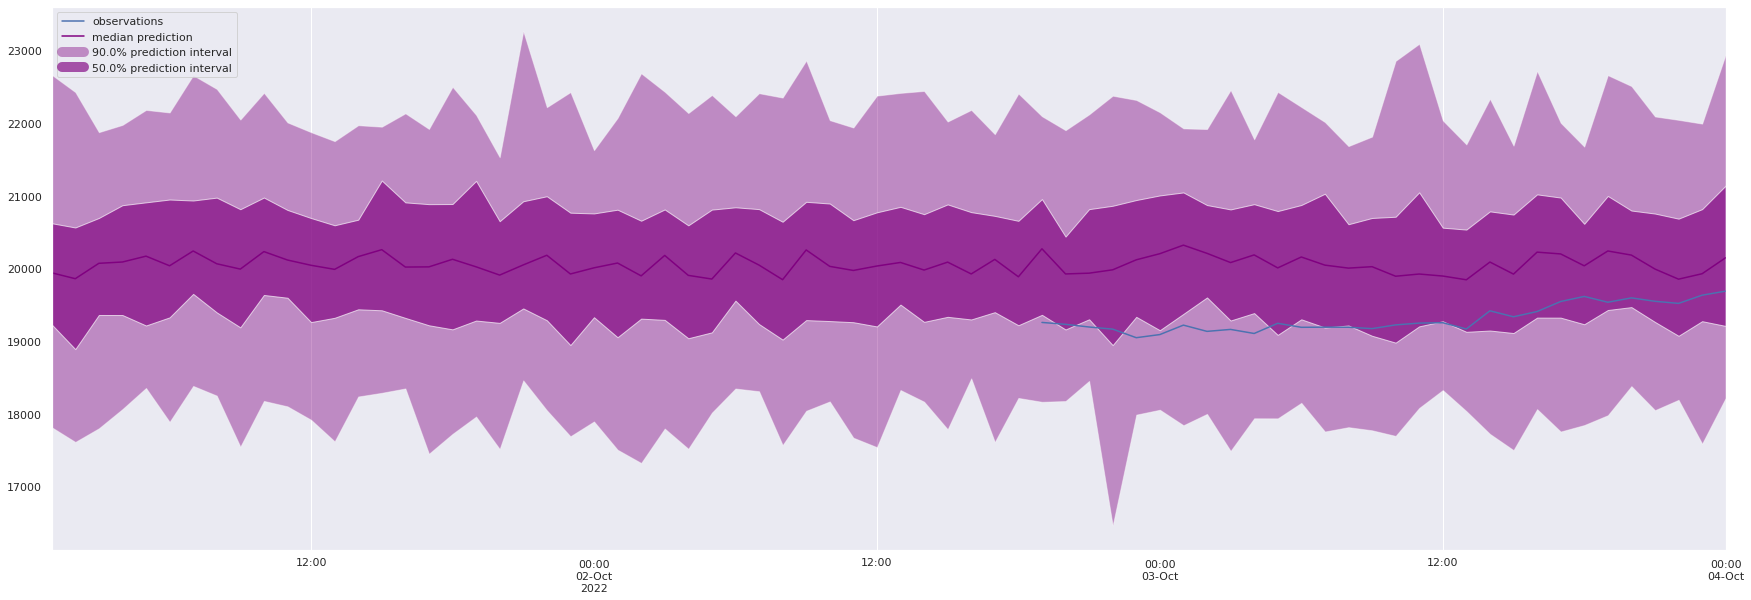

In [28]:

plot_prob_forecasts(ts_entry, forecast_entry)


In [29]:
btc_usd_h.reset_index().to_csv("bitstamp.csv")